In [1]:
from torch.utils import model_zoo
import cornet
from torch.nn import Sequential
import torch
from matplotlib import pyplot as plt
from util.activation_visualization import dataset_average, effective_receptive_field, backprop_maximization, activation_triggered_average, rescaleZeroOne, get_input_output_shape, multiplot

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [3]:
cornet_z = cornet.get_model("z", pretrained=True).module

In [4]:
seq_cornet = Sequential(cornet_z[0].conv, cornet_z[0].nonlin, cornet_z[0].pool,
                        cornet_z[1].conv, cornet_z[1].nonlin, cornet_z[1].pool,
                        cornet_z[2].conv, cornet_z[2].nonlin, cornet_z[2].pool,
                        cornet_z[3].conv, cornet_z[3].nonlin, cornet_z[3].pool)

In [5]:
seq_cornet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 512/512 [00:01<00:00, 361.70it/s]


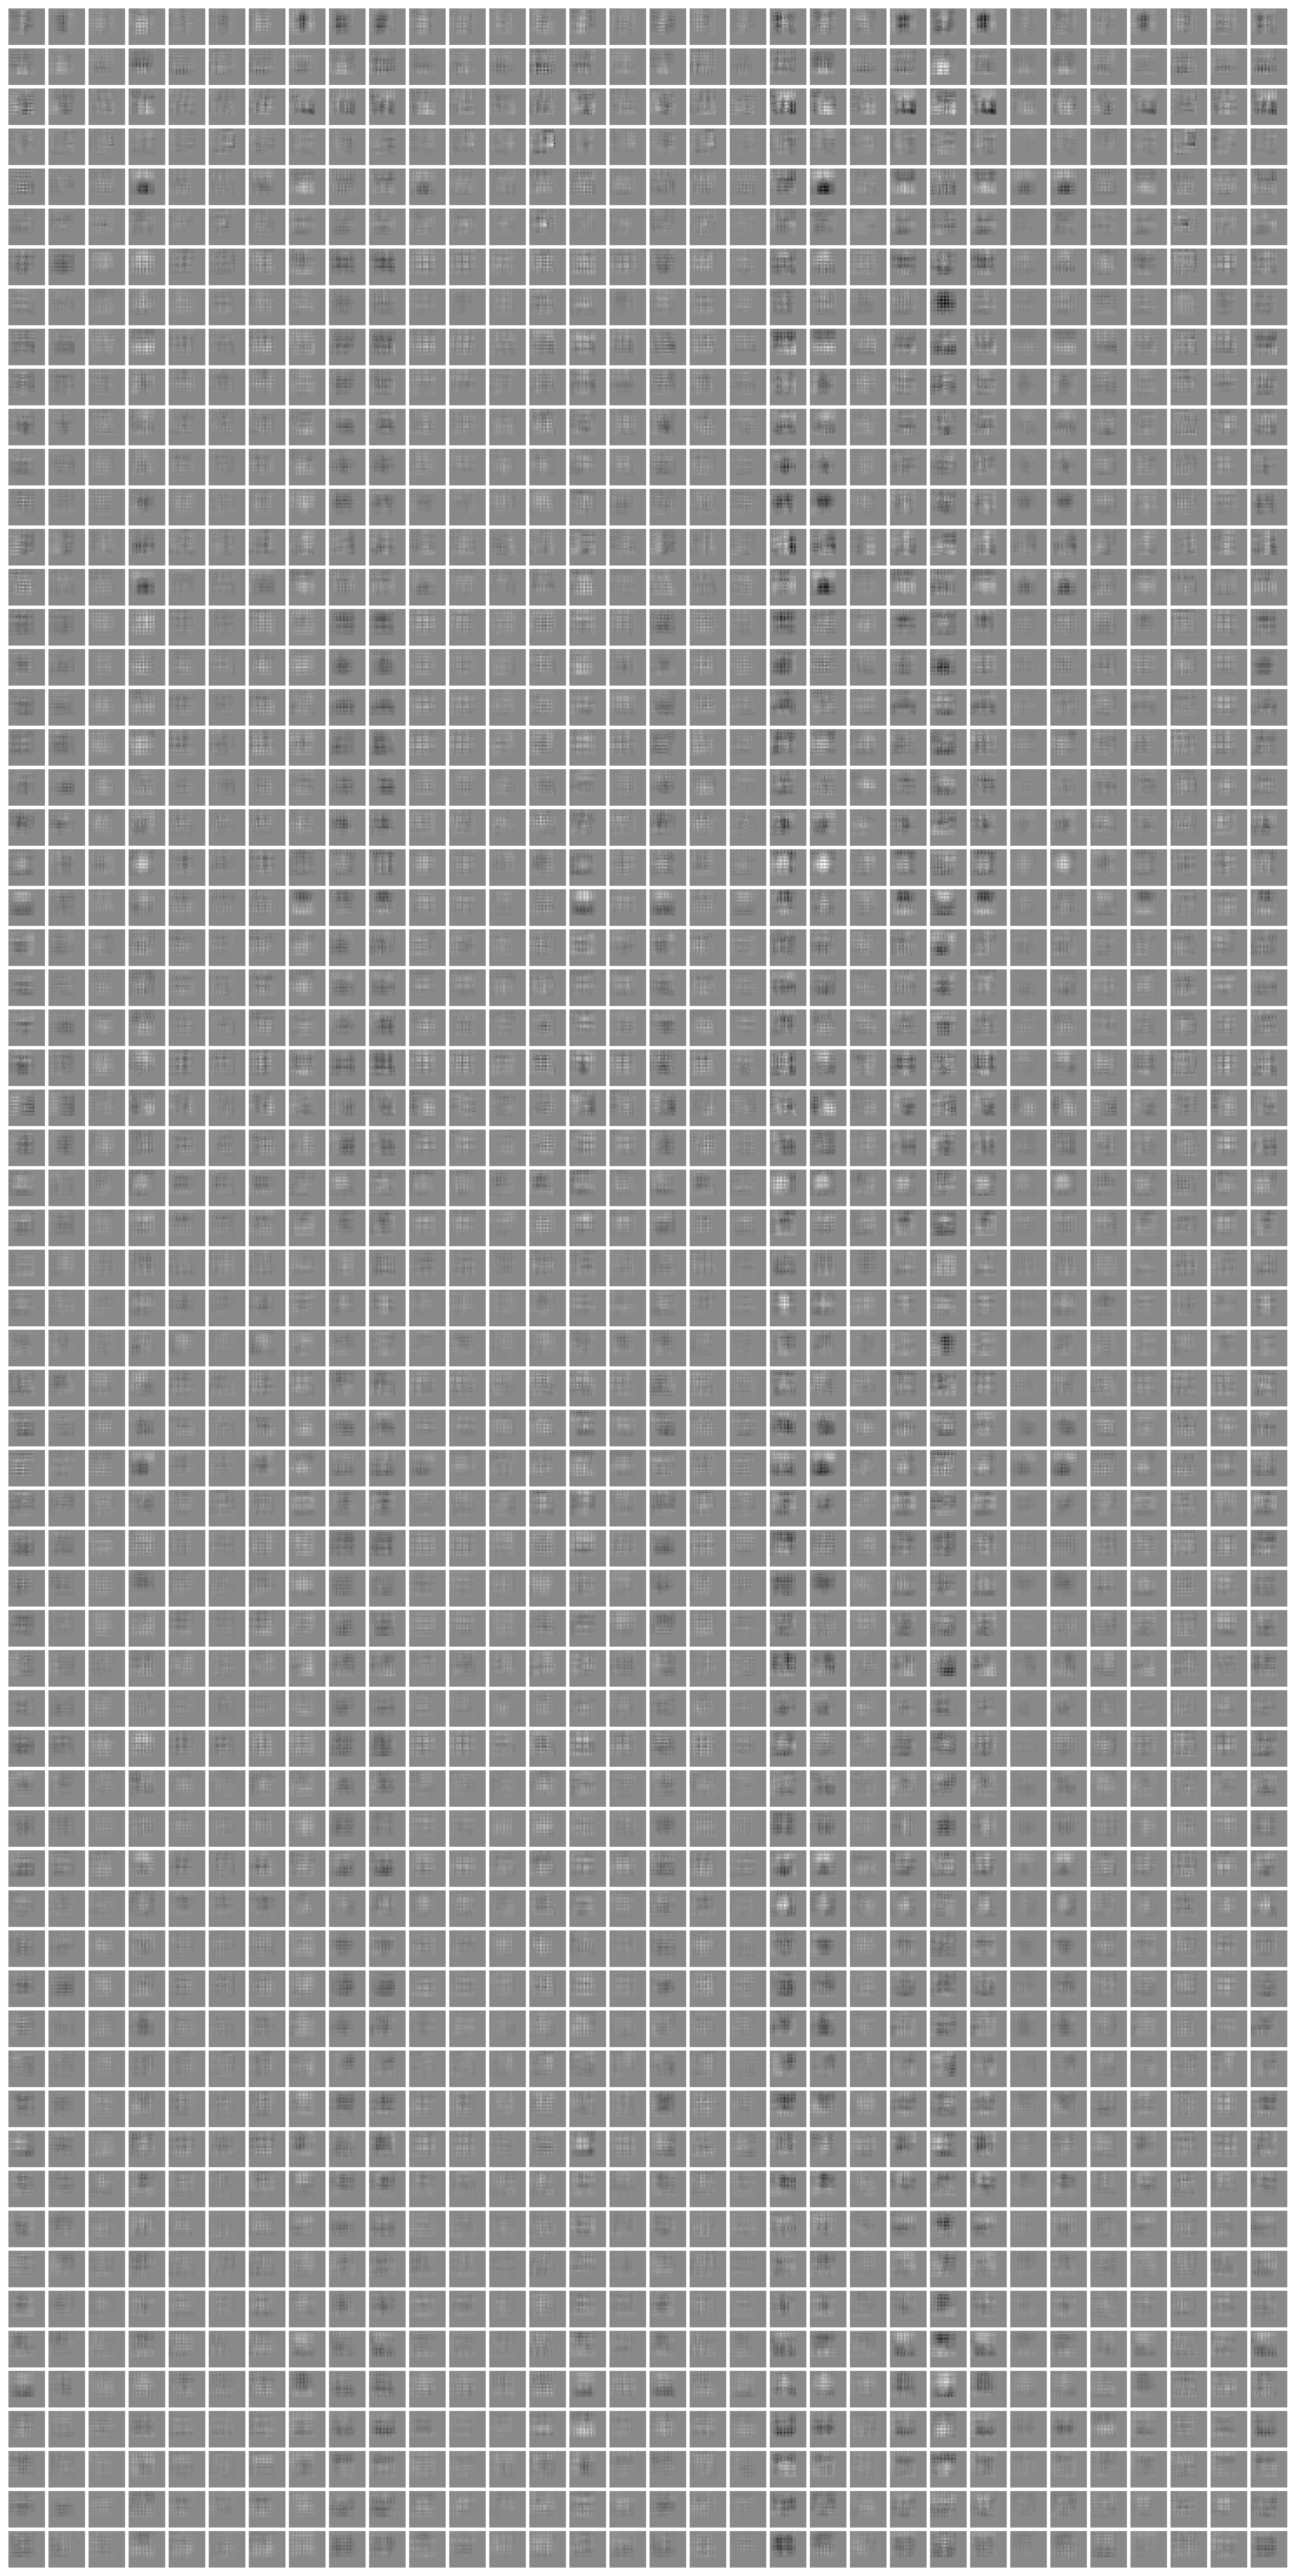

In [14]:
from torchvision import transforms
max_rfs=64
max_channels=32

layer_a = 3
layer_b = 10

eff_rfs = effective_receptive_field(seq_cornet[layer_a:layer_b], n_batch=1, fill_value=0.0, device=device) # model[0].weight.detach().cpu()# TODO: High prio: fix bug in rf size estimation! padding? dilation, stride?
plots_per_row = eff_rfs.shape[1]
max_plots = eff_rfs.shape[0]*eff_rfs.shape[1]
# order = torch.argsort(model[6].weight.sum(axis=(0,2,3)), descending=True).cpu()
sort = eff_rfs.abs().max(dim=3)[0].max(dim=2)[0].max(dim=1)[0]
# sort = eff_rfs.abs().sum(axis=(1,2,3))
order = torch.argsort(sort, descending=True)
eff_rfs = eff_rfs[order[:max_rfs], :max_channels]
eff_rfs = rescaleZeroOne(eff_rfs)
eff_rfs = transforms.Pad(1, fill=1)(eff_rfs)
plt.figure(figsize=(50,50))
plt.imshow(eff_rfs.movedim(1,2).flatten(start_dim=2,end_dim=3).flatten(0,1), cmap="gray")
plt.axis("off")
plt.show()

In [6]:
%matplotlib inline
layer_a = 3
layer_b = 4
max_rfs=32
max_channels=32

eff_rfs = effective_receptive_field(seq_cornet[layer_a:layer_b], n_batch=1, fill_value=0.0, device=device)
plots_per_row = 16
max_plots = eff_rfs.shape[0]*eff_rfs.shape[1]
# order = torch.argsort(model[6].weight.sum(axis=(0,2,3)), descending=True).cpu()
sort = eff_rfs.abs().max(dim=3)[0].max(dim=2)[0].max(dim=1)[0]
# sort = eff_rfs.abs().sum(axis=(1,2,3))
order = torch.argsort(sort, descending=True)
eff_rfs = eff_rfs[order]
if eff_rfs.shape[1] not in [1,3]:
    eff_rfs = eff_rfs.flatten(start_dim=0,end_dim=1)[:,None]
plt.figure(figsize=(5,5))
multiplot(eff_rfs, color=True, individ_rescale=True, plots_per_row=plots_per_row, max_plots=max_plots)
plt.show()

100%|██████████| 128/128 [00:09<00:00, 13.70it/s]


<Figure size 500x500 with 0 Axes>

ValueError: Image size of 4800x153600 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 4800x153600 with 8192 Axes>